# GDSCv2 Analysis - Docetaxel (10 clusters)

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
from pyBasket.common import load_obj, save_obj
from pyBasket.model import get_model_simple_bern, get_model_hierarchical_bern
from pyBasket.model import get_model_pyBasket, get_model_pyBasket_nc
from pyBasket.model import get_model_pyBasket_independent, get_model_pyBasket_independent_nc
from pyBasket.clustering import get_cluster_df_by_basket, plot_PCA, get_patient_df
from pyBasket.preprocessing import select_rf, check_rf

# Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
KMH-2,2.644470,-9.965784,7.369643,2.521319,4.211213,-9.965784,1.926462,5.212597,3.104173,3.763338,...,-6.705062,-9.965784,-1.975997,-9.965784,2.052412,-9.965784,-0.561202,-0.021777,-2.262192,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

,CNS/Brain,Bone,Prostate,Esophagus/Stomach,Bladder/Urinary Tract,Ovary/Fallopian Tube,Lymphoid,Kidney,Thyroid,Soft Tissue,...,Uterus,Pancreas,Breast,Cervix,Bowel,Peripheral Nervous System,Liver,Biliary Tract,Other,Ampulla of Vater
TGBC24TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
EGI-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TGBC1TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ETK-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
SW1710,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
KMH-2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
HTC-C3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
IHH-4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

# Do PCA and colour by basket (tissues)

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347671
 0.38132787 0.39535567 0.40877618 0.42098209]


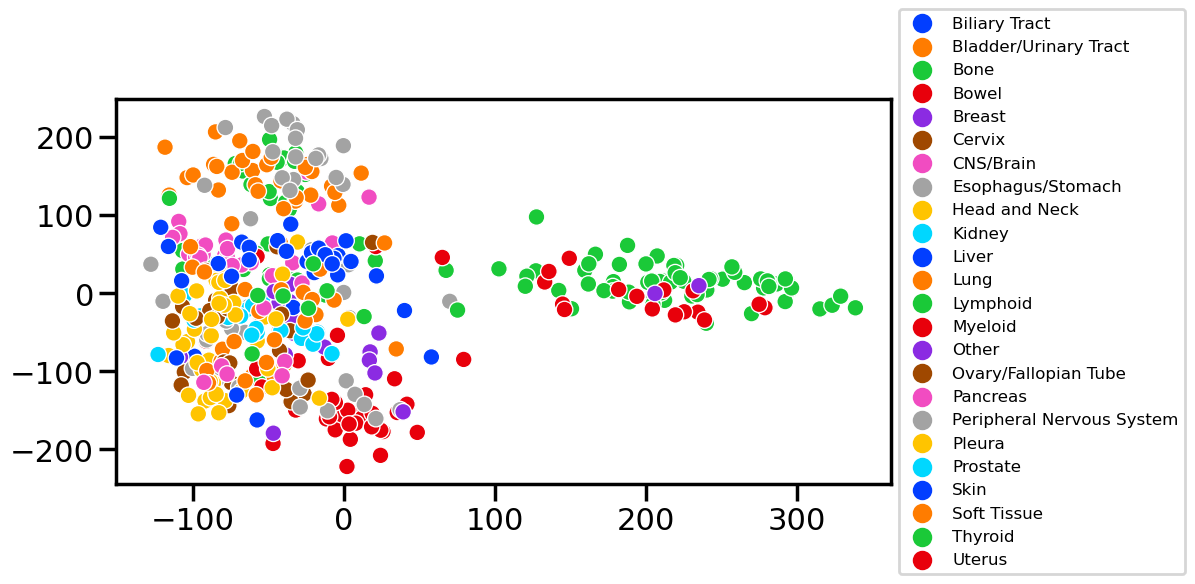

In [10]:
_ = plot_PCA(expr_df, n_components=10, hue=tissues)

# Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

,Bortezomib,Entinostat,Sirolimus,Docetaxel,Gemcitabine,Crizotinib,Lapatinib,Vorinostat,Erlotinib,Paclitaxel,Pictilisib
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,0.184836,0.142503,0.304184,0.111977,0.596289,0.077036,0.048663,0.240865,0.069736,0.015539,0.254125
23132/87,0.228235,0.121580,0.208475,0.232821,0.407328,0.018921,0.172438,0.235145,0.124366,0.025982,0.431203
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
YH-13,0.174638,0.019992,0.157624,0.211467,0.359880,0.008977,0.069979,0.144077,0.108331,0.087400,0.349741
YKG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YMB-1-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YT,0.230123,NaN,0.212004,0.113564,0.666782,NaN,0.084477,0.235547,0.000000,0.000000,0.172903


In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

## Collect the samples and responses for the drug

In [13]:
drug_name = 'Docetaxel'

In [14]:
samples = tissue_df.index.values
response_dict = response_df[drug_name].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [15]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.229496
1,Biliary Tract,EGI-1,0.027301
2,Biliary Tract,TGBC1TKB,0.055122
3,Biliary Tract,ETK-1,0.235336
4,Bladder/Urinary Tract,SW1710,0.181703
...,...,...,...
441,Thyroid,ASH-3,0.161333
442,Thyroid,KMH-2,NaN
443,Thyroid,HTC-C3,0.135717
444,Thyroid,IHH-4,0.260577


## Drop all the NaN responses

In [16]:
df = df.dropna(subset=['responses'])
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.229496
1,Biliary Tract,EGI-1,0.027301
2,Biliary Tract,TGBC1TKB,0.055122
3,Biliary Tract,ETK-1,0.235336
4,Bladder/Urinary Tract,SW1710,0.181703
...,...,...,...
440,Thyroid,WRO,0.104901
441,Thyroid,ASH-3,0.161333
443,Thyroid,HTC-C3,0.135717
444,Thyroid,IHH-4,0.260577


In [17]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [18]:
df.groupby('tissues').count()

,samples,responses
tissues,,
Biliary Tract,4,4
Bladder/Urinary Tract,5,5
Bone,25,25
Bowel,29,29
Breast,11,11
CNS/Brain,15,15
Cervix,13,13
Esophagus/Stomach,19,19
Head and Neck,16,16


In [19]:
df['responses'].max(), df['responses'].min()

(0.430940178074287, 0.0139772413690281)

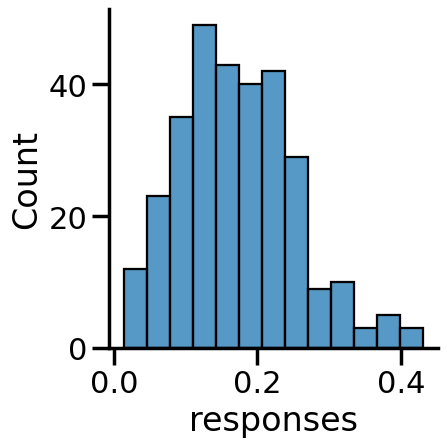

In [20]:
sns.displot(df['responses'])

In [21]:
df['responses'].mean(), df['responses'].median()

(0.17279479915578644, 0.164925267594393)

# Select baskets for analysis

Select some baskets

In [22]:
# basket_names = [
#     'Lymphoid',
#     'Bowel',
#     'Bone',
#     'Lung',
#     'Esophagus/Stomach'
# ]

Use all baskets

In [23]:
basket_names = df['tissues'].unique()
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [24]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.229496
1,Biliary Tract,EGI-1,0.027301
2,Biliary Tract,TGBC1TKB,0.055122
3,Biliary Tract,ETK-1,0.235336
4,Bladder/Urinary Tract,SW1710,0.181703
...,...,...,...
298,Thyroid,WRO,0.104901
299,Thyroid,ASH-3,0.161333
300,Thyroid,HTC-C3,0.135717
301,Thyroid,IHH-4,0.260577


In [25]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((303, 19957), (446, 19957))

In [26]:
expr_df_filtered

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,3.205753,-9.965784,7.307272,-0.607968,0.481533,-9.965784,0.725387,5.847553,4.118905,4.821918,...,-6.475129,-6.749269,-9.965784,-9.965784,2.933364,-9.965784,-2.224737,-1.366209,-1.616199,-9.965784
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


In [27]:
drug_response = df_filtered.set_index('samples').drop(columns=['tissues'])
drug_response

,responses
samples,
TGBC24TKB,0.229496
EGI-1,0.027301
TGBC1TKB,0.055122
ETK-1,0.235336
SW1710,0.181703
...,...
WRO,0.104901
ASH-3,0.161333
HTC-C3,0.135717


## Feature selection using random forest

In [28]:
try: # try to load previously selected features
    fname = os.path.join('results', '%s_expr_df_selected.p' % drug_name)
    expr_df_selected = load_obj(fname)
    
except FileNotFoundError: # if not found, then re-run feature selection
    expr_df_selected = select_rf(expr_df_filtered, drug_response, n_splits=5, percentile_threshold=90, top_genes=500)
    save_obj(expr_df_selected, fname)

In [29]:
importance_df = check_rf(expr_df_selected, drug_response, test_size=0.2)

Test set results using selected features:
MSE: 0.005610301850483374
R^2: 0.3290217313953814


In [30]:
expr_df_selected

,ENSG00000087085.15,ENSG00000100353.18,ENSG00000106080.11,ENSG00000128203.7,ENSG00000129518.9,ENSG00000153310.19,ENSG00000159496.14,ENSG00000160191.18,ENSG00000171097.14,ENSG00000088387.19,...,ENSG00000118363.12,ENSG00000118855.21,ENSG00000119714.11,ENSG00000120149.9,ENSG00000120662.16,ENSG00000120686.12,ENSG00000120699.13,ENSG00000120885.22,ENSG00000121067.19,ENSG00000121101.15
TGBC24TKB,-1.488359,7.828958,3.222369,0.207871,4.729741,6.551517,-1.449346,-0.457157,4.164757,4.515712,...,7.535028,3.919286,-3.558991,6.813666,4.294419,5.126871,5.823440,7.027454,5.312538,-1.662541
EGI-1,-3.597939,7.691249,2.752279,1.225718,5.187351,6.158721,-1.006019,4.232133,4.301371,6.842691,...,7.437596,4.502653,2.379004,2.871238,4.417935,5.361334,5.444781,4.168388,5.822489,-0.949471
TGBC1TKB,-0.567522,7.647644,3.452910,1.241864,4.096392,6.255598,-1.347924,1.309242,2.281707,5.170906,...,8.126880,4.334643,-4.181515,2.460680,3.765419,5.205198,5.171663,4.323032,4.846360,-1.753218
ETK-1,-0.147366,7.076886,4.066674,0.308964,4.900237,7.166964,-2.262952,0.413956,2.018295,4.443640,...,7.524266,5.232804,0.311753,-1.892707,3.533109,4.525659,5.179682,4.576526,4.718725,-0.827075
SW1710,-4.040308,7.331458,3.897158,1.214325,4.485617,6.326129,-1.127516,2.257350,4.572155,3.644443,...,6.837013,4.648463,1.485283,-9.965784,3.255783,4.877554,4.496838,8.526298,4.979050,-0.839284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,-4.080836,8.486243,2.126377,0.593777,5.467867,5.534940,-1.616910,-4.804729,3.400414,5.050369,...,6.734176,3.589542,-3.887693,-9.965784,1.477741,5.860183,4.292178,4.039690,4.352914,-1.609019
ASH-3,-4.948490,8.285969,3.629065,2.046983,5.440072,5.109707,1.774833,-5.568976,3.810476,4.583850,...,6.987159,4.539537,3.745115,0.748136,3.675178,5.356144,5.287416,1.880460,4.819082,-0.027310
HTC-C3,-2.316761,8.082098,2.983069,0.605742,5.519269,5.747982,-1.741040,-7.027453,4.097008,7.133304,...,6.636683,5.633005,2.901546,-9.965784,4.417331,5.603408,5.203686,-0.941250,5.107695,-0.614788
IHH-4,-3.030080,8.673622,3.494538,0.203372,5.108066,4.968381,-1.006450,-4.598347,2.004973,7.147645,...,7.103800,5.211237,2.975887,-9.965784,4.848673,5.936185,5.566942,3.329870,5.036894,-0.311707


## Do PCA again on these samples

Before feature selection (using all 19957 transcripts)

PCA explained variance [0.13801374 0.23045013 0.29135664 0.32372722 0.34682604 0.36668807
 0.38184177 0.39640329 0.40971563 0.4217204 ]


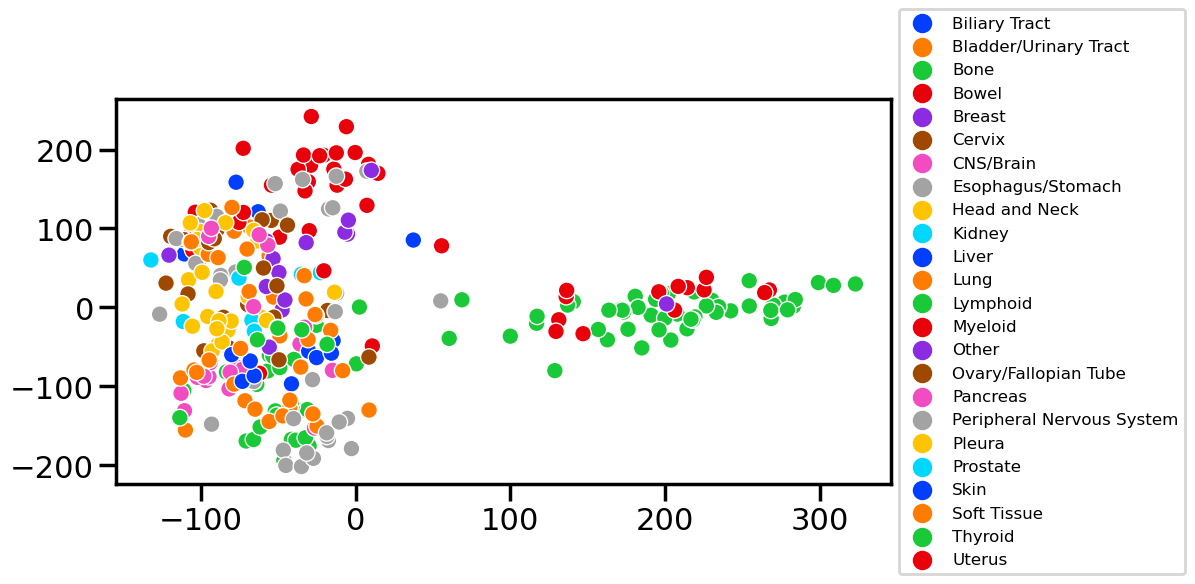

In [31]:
pc1, pc2 = plot_PCA(expr_df_filtered, n_components=10, hue=df_filtered['tissues'].values)

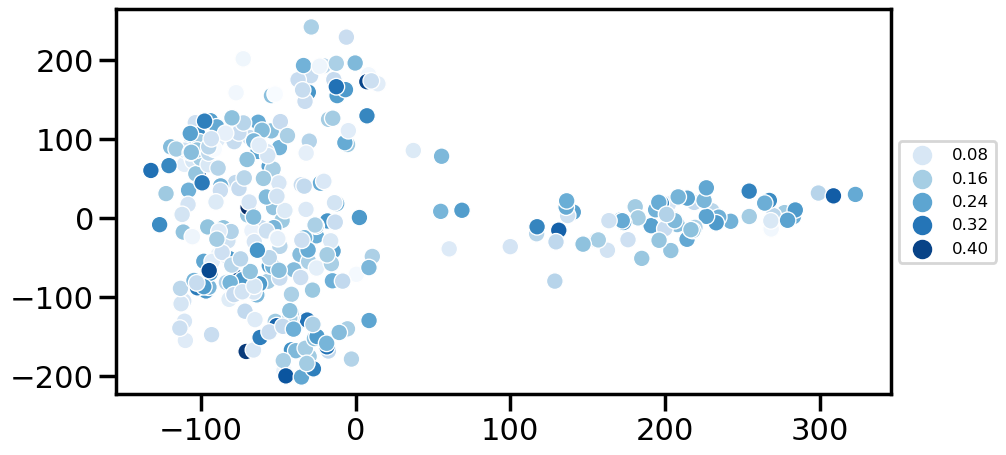

In [32]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

After feature selection (using 500 transcripts)

PCA explained variance [0.1297369  0.19969932 0.260079   0.301874   0.33328926 0.36026292
 0.38032791 0.39935341 0.41759842 0.43488062]


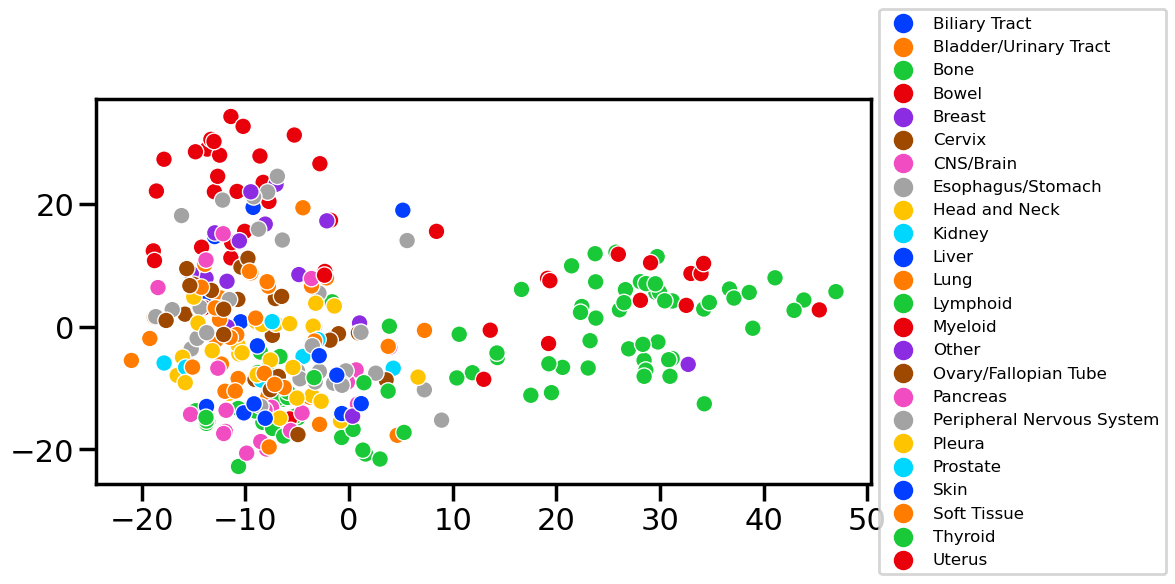

In [33]:
pc1, pc2 = plot_PCA(expr_df_selected, n_components=10, hue=df_filtered['tissues'].values)

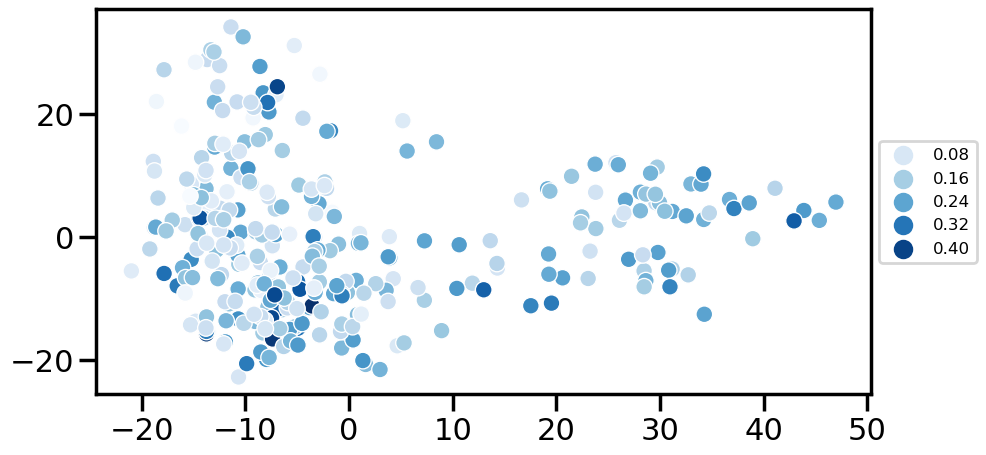

In [34]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

# Try clustering

In [35]:
expr_df_selected.shape

(303, 500)

In [36]:
classes = df_filtered.set_index('samples')
classes

,tissues,responses
samples,,
TGBC24TKB,Biliary Tract,0.229496
EGI-1,Biliary Tract,0.027301
TGBC1TKB,Biliary Tract,0.055122
ETK-1,Biliary Tract,0.235336
SW1710,Bladder/Urinary Tract,0.181703
...,...,...
WRO,Thyroid,0.104901
ASH-3,Thyroid,0.161333
HTC-C3,Thyroid,0.135717


In [37]:
C = 5

In [38]:
kmeans = KMeans(n_clusters=C, random_state=42)
kmeans.fit(expr_df_selected)

cluster_labels = kmeans.labels_
cluster_labels

array([3, 3, 1, 1, 0, 1, 0, 0, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 3, 1, 0, 0, 1, 1, 0, 2, 1, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1, 1, 0, 3, 3,
       1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2,
       3, 2, 1, 1, 2, 1, 2, 3, 2, 2, 2, 2, 2, 3, 2, 4, 4, 4, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 3, 4, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,

PCA explained variance [0.1297369  0.19969932 0.260079   0.301874   0.33328926 0.36026292
 0.38032791 0.39935341 0.41759842 0.43488062]


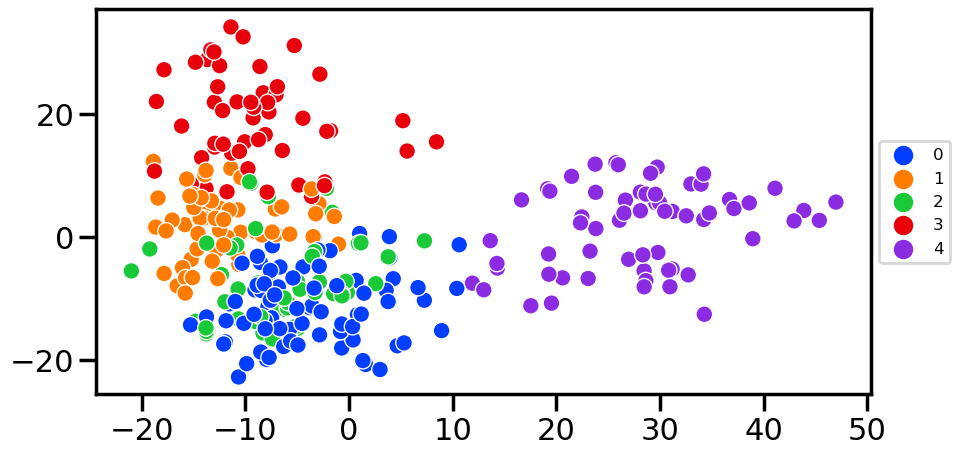

In [39]:
_ = plot_PCA(expr_df_selected, n_components=10, hue=cluster_labels)

# Run basket trial analysis

In [40]:
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [41]:
K = len(basket_names)
K, C

(24, 5)

Create clustering dataframe

In [42]:
class_labels = classes.tissues.values
len(class_labels), len(cluster_labels)

(303, 303)

In [43]:
cluster_df = get_cluster_df_by_basket(class_labels, cluster_labels, normalise=False)
cluster_df

,sk_0,sk_1,sk_2,sk_3,sk_4
Biliary Tract,0,2,0,2,0
Bladder/Urinary Tract,3,2,0,0,0
Bone,9,0,16,0,0
Bowel,1,3,0,25,0
Breast,1,1,0,9,0
CNS/Brain,14,0,1,0,0
Cervix,3,8,1,1,0
Esophagus/Stomach,1,10,0,8,0
Head and Neck,3,13,0,0,0
Kidney,4,1,0,0,0


<AxesSubplot: >

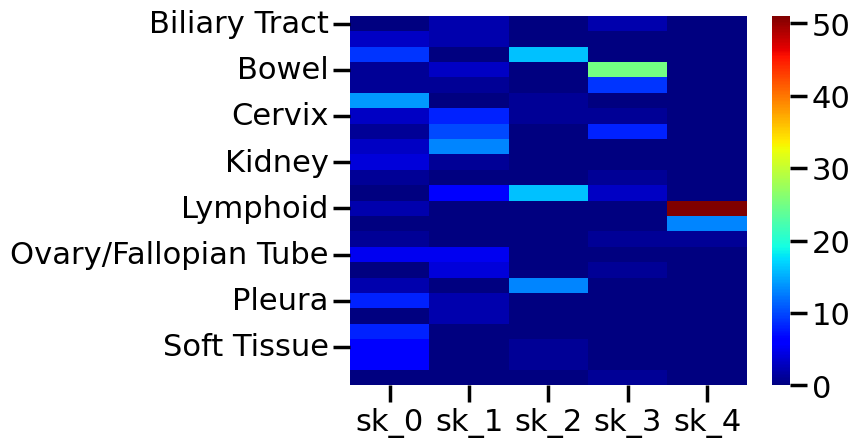

In [44]:
sns.heatmap(cluster_df, cmap='jet')

## Prepare patient data

In [45]:
patient_df = get_patient_df(df_filtered, cluster_labels)

In [46]:
patient_df

,tissues,responses,basket_number,cluster_number,responsive
samples,,,,,
TGBC24TKB,Biliary Tract,0.229496,0,3,0
EGI-1,Biliary Tract,0.027301,0,3,1
TGBC1TKB,Biliary Tract,0.055122,0,1,1
ETK-1,Biliary Tract,0.235336,0,1,0
SW1710,Bladder/Urinary Tract,0.181703,1,0,0
...,...,...,...,...,...
WRO,Thyroid,0.104901,22,0,1
ASH-3,Thyroid,0.161333,22,0,1
HTC-C3,Thyroid,0.135717,22,0,1


## Define models

No. of samples to collect before and after burn-in during MCMC.

In [47]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [48]:
model_s = get_model_simple_bern(patient_df, K, C)

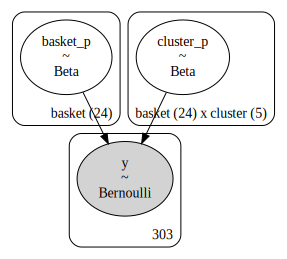

In [49]:
pm.model_to_graphviz(model_s)

In [50]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 71 seconds.


In [51]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
basket_p[Biliary Tract],0.64,0.22,0.27,1.00,0.0,0.0,31904.0,12609.0,1.0
basket_p[Bladder/Urinary Tract],0.69,0.22,0.31,1.00,0.0,0.0,32783.0,12837.0,1.0
basket_p[Bone],0.64,0.18,0.37,1.00,0.0,0.0,19620.0,12169.0,1.0
basket_p[Bowel],0.80,0.12,0.61,1.00,0.0,0.0,18366.0,10639.0,1.0
basket_p[Breast],0.73,0.17,0.44,1.00,0.0,0.0,21068.0,11659.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[Uterus, 0]",0.50,0.29,0.01,0.95,0.0,0.0,47004.0,11790.0,1.0
"cluster_p[Uterus, 1]",0.50,0.29,0.04,0.98,0.0,0.0,37690.0,11717.0,1.0
"cluster_p[Uterus, 2]",0.50,0.28,0.04,0.97,0.0,0.0,46263.0,12559.0,1.0
"cluster_p[Uterus, 3]",0.67,0.24,0.25,1.00,0.0,0.0,39985.0,12878.0,1.0


In [52]:
# az.plot_ess(
#     trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

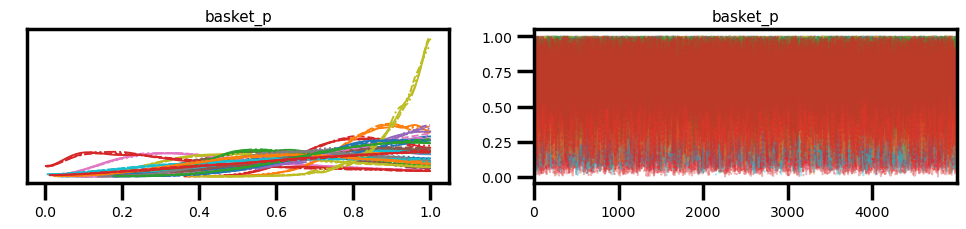

In [53]:
az.plot_trace(trace_s, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

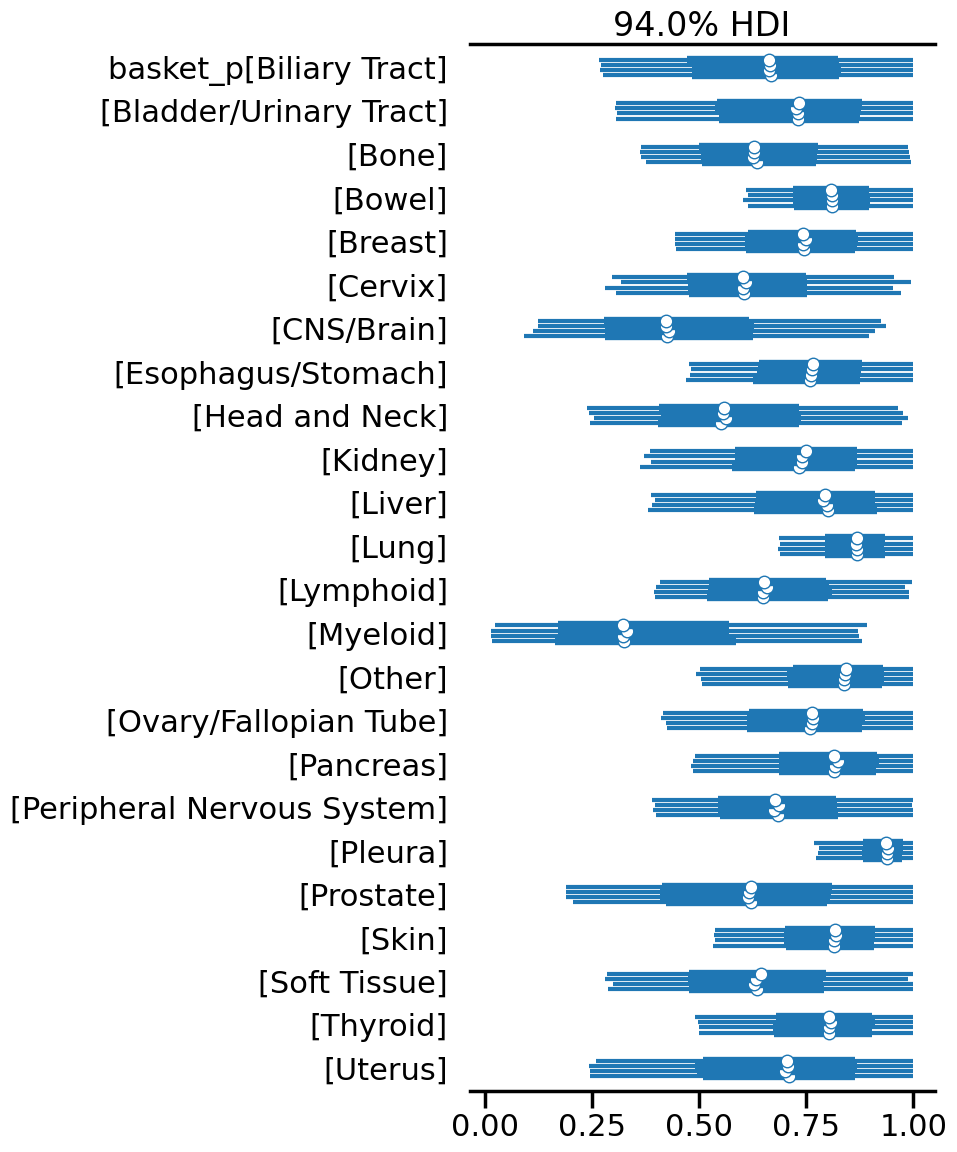

In [54]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [55]:
stacked_s = az.extract(trace_s)

In [56]:
inferred_basket_p = np.mean(stacked_s.basket_p.values, axis=1)

In [57]:
inferred_cluster_p = np.mean(stacked_s.cluster_p.values, axis=2)

In [58]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (C, 1)).T
inferred_mat_s = inferred_basket_p_tiled * inferred_cluster_p

### pyBasket model (initial)

Same as above but add priors.

In [59]:
model_h1 = get_model_pyBasket_independent(patient_df, K, C)

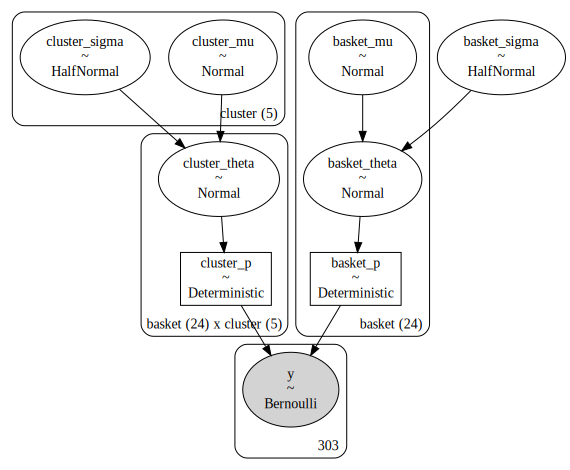

In [60]:
pm.model_to_graphviz(model_h1)

In [61]:
# with model_h1:
#     trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

This is the one we actually use after reparameterisation.

In [62]:
model_h1_nc = get_model_pyBasket_independent_nc(patient_df, K, C)

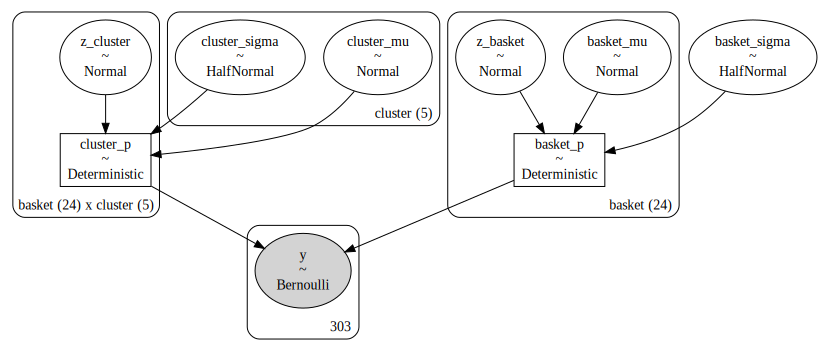

In [63]:
pm.model_to_graphviz(model_h1_nc)

In [64]:
with model_h1_nc:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 321 seconds.


In [65]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[Biliary Tract],0.05,0.98,-1.80,1.87,0.01,0.01,26145.0,15795.0,1.0
z_basket[Bladder/Urinary Tract],0.07,0.98,-1.76,1.93,0.01,0.01,23938.0,16428.0,1.0
z_basket[Bone],-0.00,0.96,-1.78,1.84,0.01,0.01,18614.0,16039.0,1.0
z_basket[Bowel],0.14,0.98,-1.73,1.96,0.01,0.01,23164.0,14882.0,1.0
z_basket[Breast],0.09,0.97,-1.73,1.91,0.01,0.01,22709.0,15880.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[Uterus, 0]",0.80,0.19,0.41,1.00,0.00,0.00,15203.0,14662.0,1.0
"cluster_p[Uterus, 1]",0.77,0.16,0.49,1.00,0.00,0.00,15069.0,11642.0,1.0
"cluster_p[Uterus, 2]",0.80,0.19,0.43,1.00,0.00,0.00,14393.0,15395.0,1.0
"cluster_p[Uterus, 3]",0.87,0.11,0.67,1.00,0.00,0.00,14252.0,13168.0,1.0


In [66]:
# az.plot_ess(
#     trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

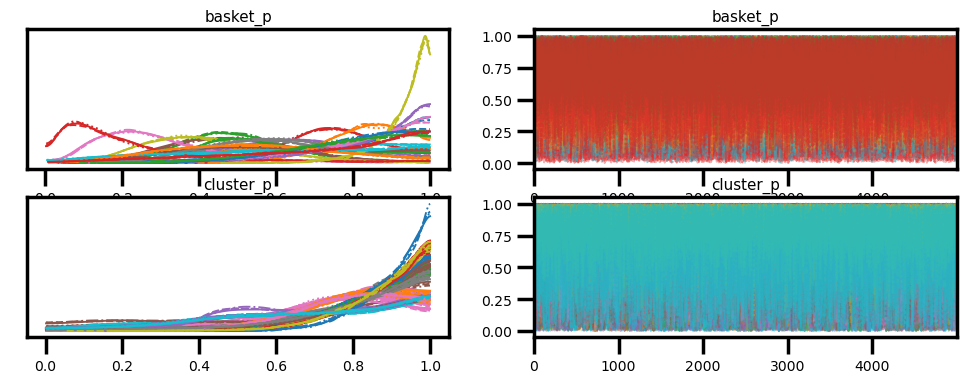

In [67]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

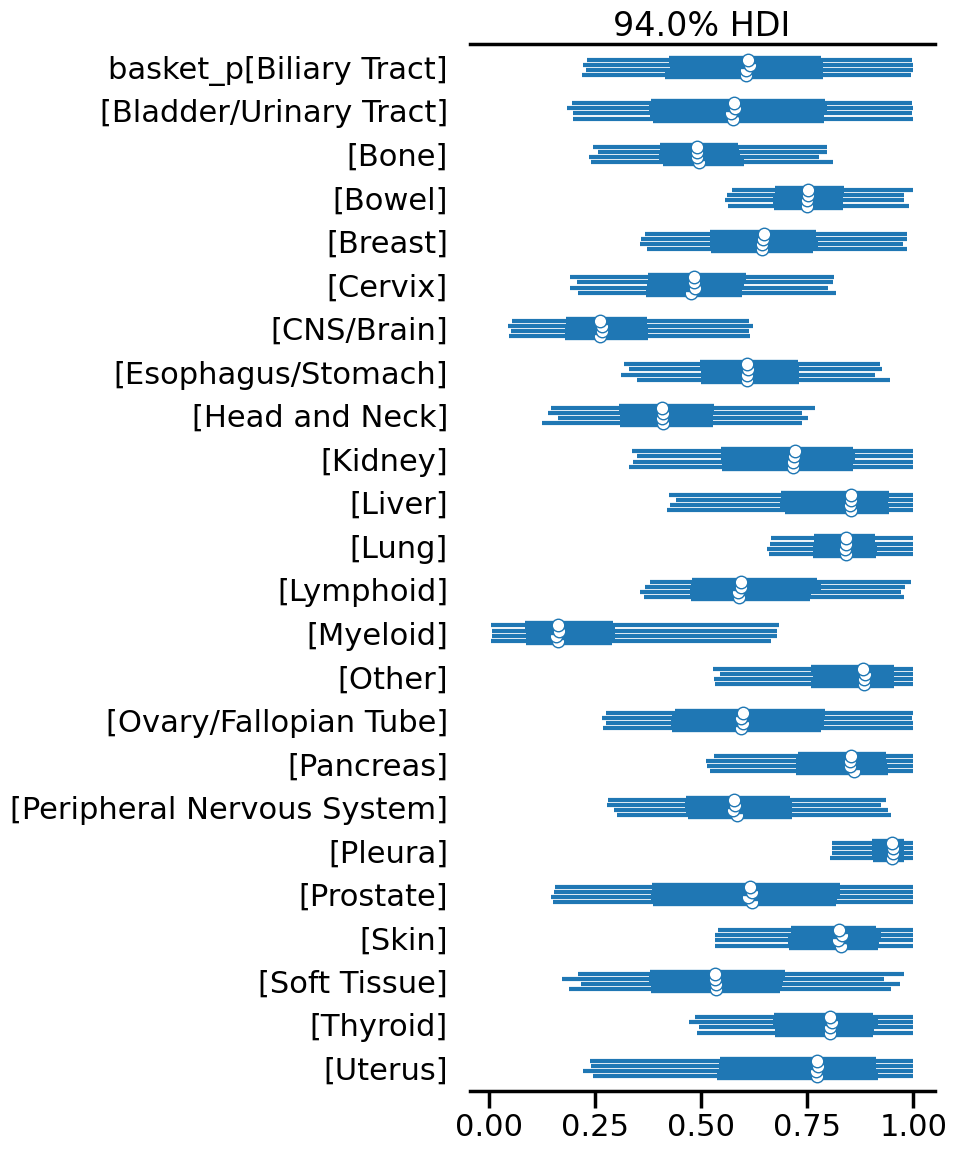

In [68]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [69]:
stacked_h1 = az.extract(trace_h1)

In [70]:
inferred_basket_p = np.mean(stacked_h1.basket_p.values, axis=1)

In [71]:
inferred_cluster_p = np.mean(stacked_h1.cluster_p.values, axis=2)

In [72]:
inferred_basket_p_tiled = np.tile(inferred_basket_p, (C, 1)).T
inferred_mat_h1 = inferred_basket_p_tiled * inferred_cluster_p

### pyBasket model (logistic regression)

Should be the final version used in the paper.

In [73]:
model_pyBasket = get_model_pyBasket(patient_df, K, C)

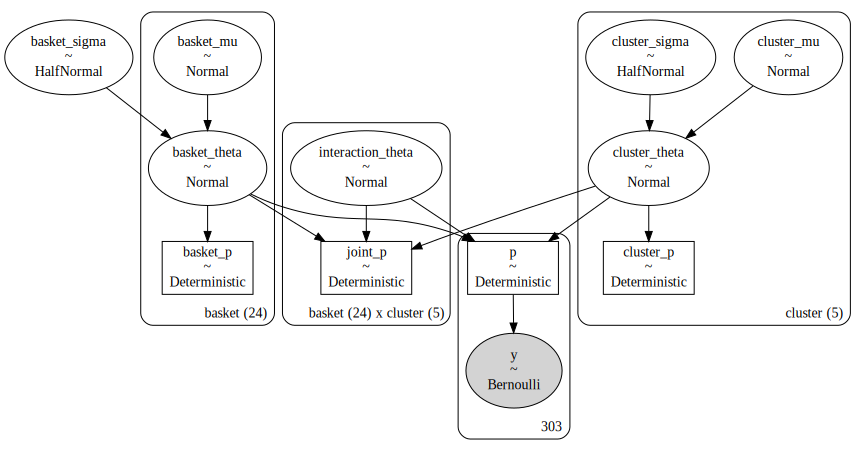

In [74]:
pm.model_to_graphviz(model_pyBasket)

In [75]:
# with model_pyBasket:
#     trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [76]:
model_pyBasket_nc = get_model_pyBasket_nc(patient_df, K, C)

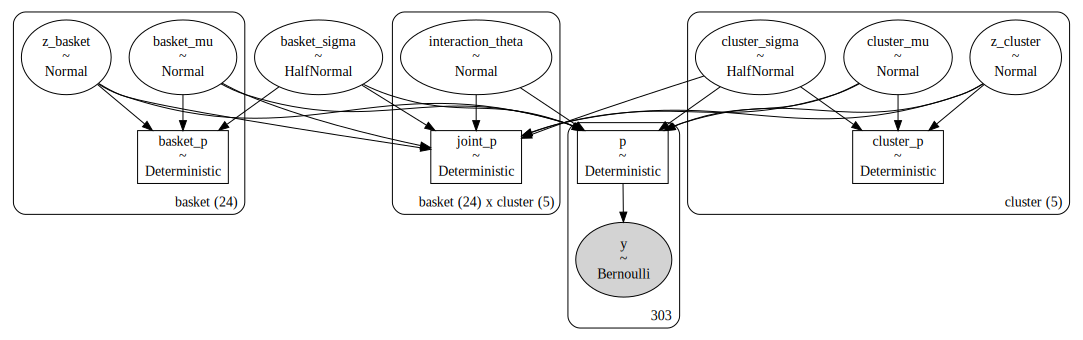

In [77]:
pm.model_to_graphviz(model_pyBasket_nc)

In [78]:
with model_pyBasket_nc:
    trace_pyBasket = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma, interaction_theta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 658 seconds.


In [79]:
az.summary(trace_pyBasket).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[Biliary Tract],-0.04,0.97,-1.85,1.80,0.00,0.01,34898.0,15599.0,1.0
z_basket[Bladder/Urinary Tract],-0.03,0.98,-1.84,1.82,0.00,0.01,33368.0,14584.0,1.0
z_basket[Bone],-0.04,0.98,-1.88,1.79,0.00,0.01,32149.0,15365.0,1.0
z_basket[Bowel],-0.03,0.97,-1.81,1.88,0.01,0.01,30502.0,14858.0,1.0
z_basket[Breast],-0.04,0.97,-1.86,1.77,0.00,0.01,34921.0,15741.0,1.0
...,...,...,...,...,...,...,...,...,...
p[298],0.68,0.17,0.37,0.96,0.00,0.00,20394.0,15134.0,1.0
p[299],0.68,0.17,0.37,0.96,0.00,0.00,20394.0,15134.0,1.0
p[300],0.68,0.17,0.37,0.96,0.00,0.00,20394.0,15134.0,1.0
p[301],0.68,0.17,0.37,0.96,0.00,0.00,20394.0,15134.0,1.0


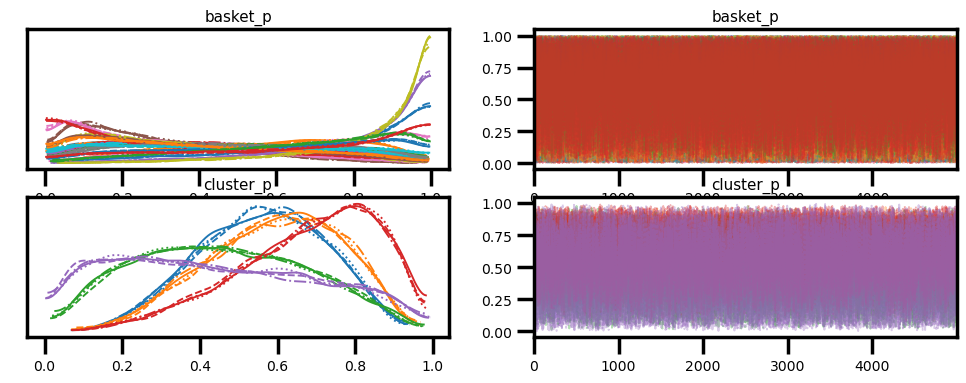

In [80]:
az.plot_trace(trace_pyBasket, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

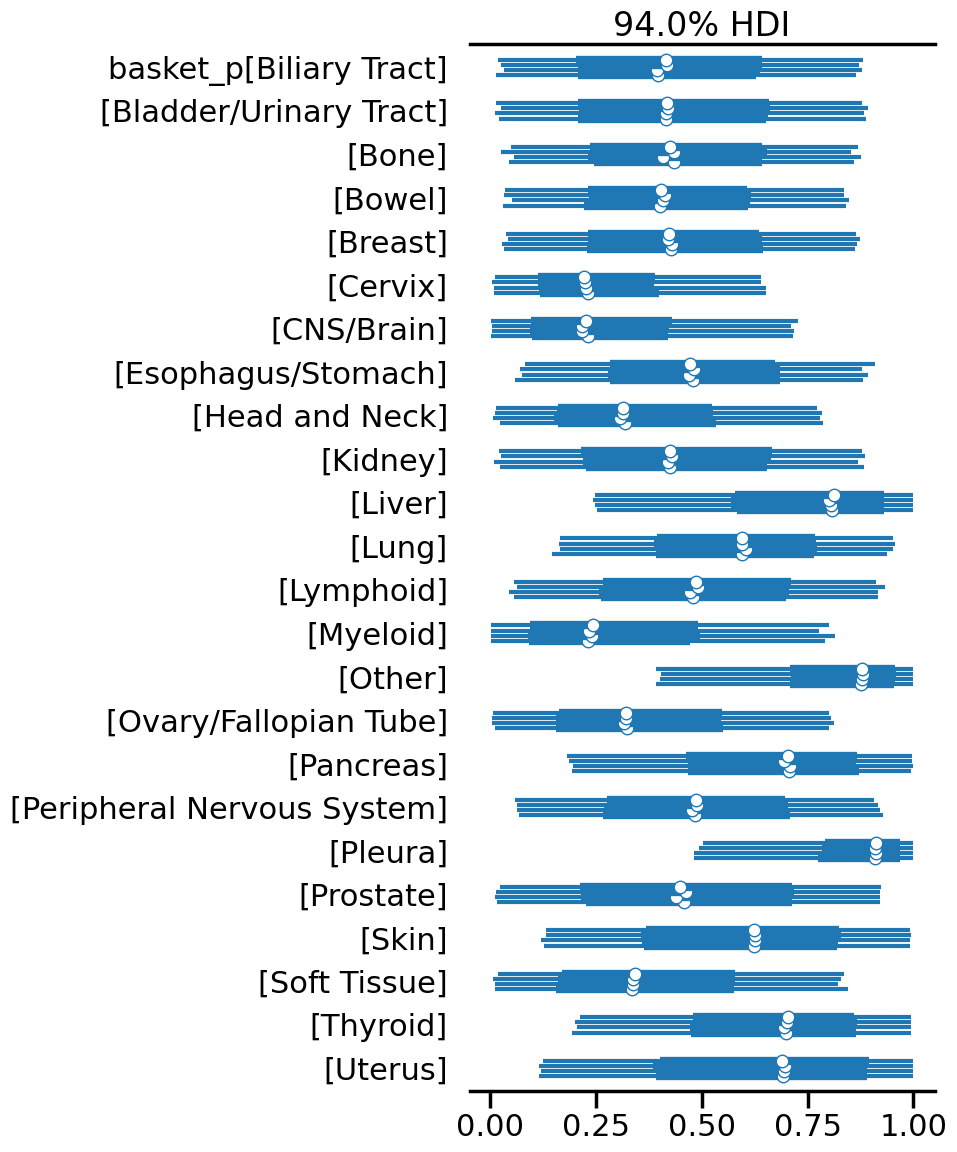

In [81]:
az.plot_forest(trace_pyBasket, var_names=['basket_p'])

In [82]:
stacked_pyBasket = az.extract(trace_pyBasket)

In [83]:
inferred_basket_p = np.mean(stacked_pyBasket.basket_p.values, axis=1)

In [84]:
inferred_cluster_p = np.mean(stacked_pyBasket.cluster_p.values, axis=1)

In [85]:
inferred_joint_p = np.mean(stacked_pyBasket.joint_p.values, axis=2)

## Compare the matrices

In [86]:
predicted_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
predicted_basket_s_df = pd.DataFrame({'prob': predicted_basket_s, 'basket': range(len(predicted_basket_s))})

predicted_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
predicted_basket_h1_df = pd.DataFrame({'prob': predicted_basket_h1, 'basket': range(len(predicted_basket_h1))})

predicted_basket_h2 = np.mean(stacked_pyBasket.basket_p.values, axis=1)
predicted_basket_h2_df = pd.DataFrame({'prob': predicted_basket_h2, 'basket': range(len(predicted_basket_h2))})

Text(0.5, 1.0, 'Inferred (pyBasket)')

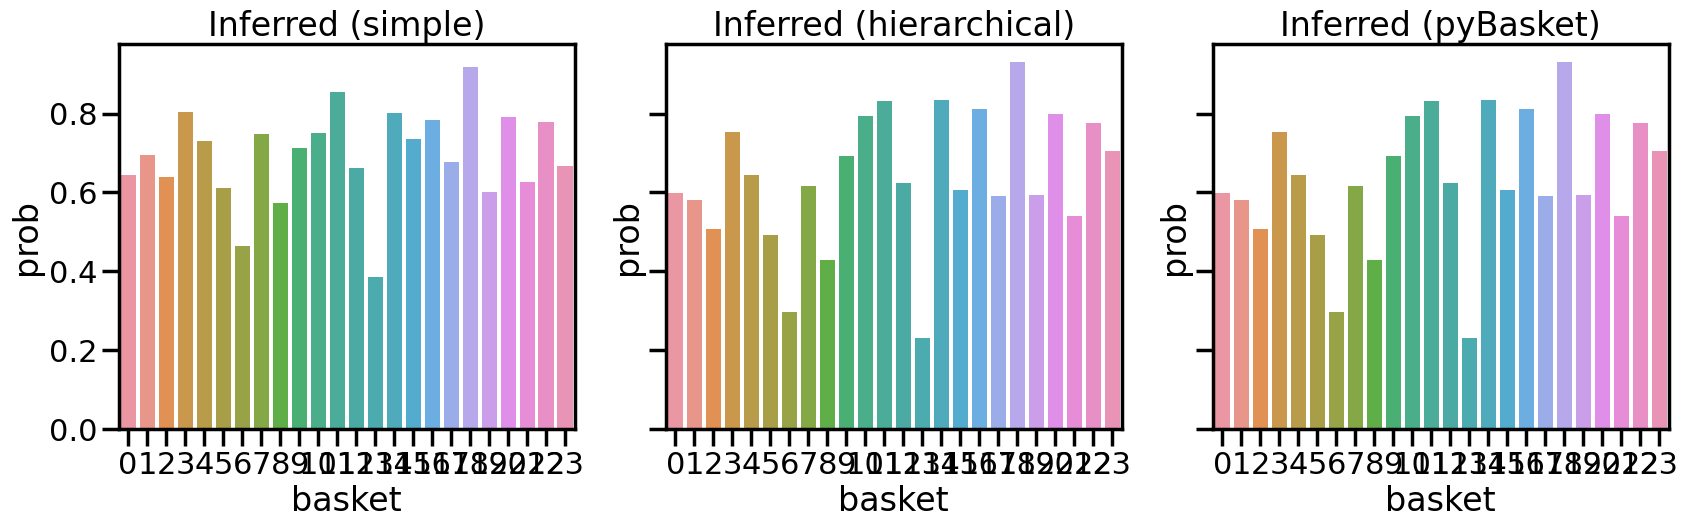

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('Inferred (simple)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('Inferred (hierarchical)')

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('Inferred (pyBasket)')

In [88]:
predicted_cluster_s = inferred_mat_s
predicted_cluster_h1 = inferred_mat_h1
predicted_cluster_h2 = inferred_joint_p

Text(1321.8954248366013, 0.5, 'Baskets')

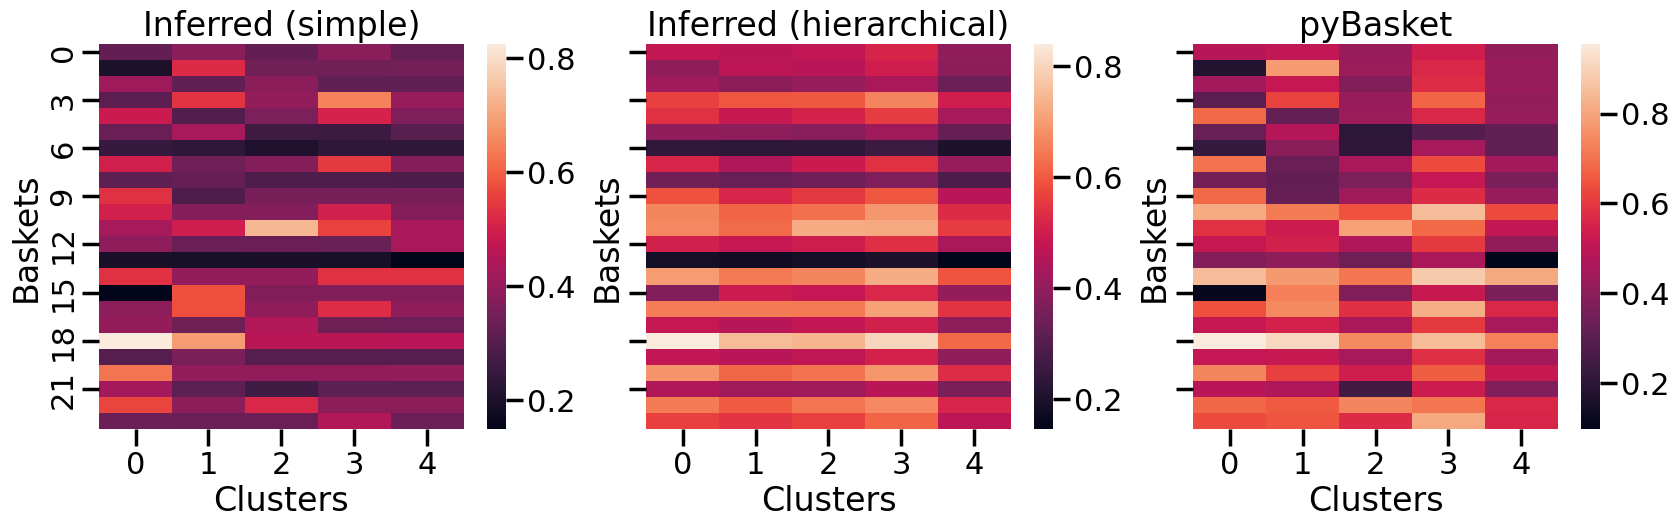

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
    
sns.heatmap(predicted_cluster_s, ax=ax[0])
ax[0].set_title('Inferred (simple)')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h1, ax=ax[1])
ax[1].set_title('Inferred (hierarchical)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(predicted_cluster_h2, ax=ax[2])
ax[2].set_title('pyBasket')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')

## 4. Model comparison

In [90]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [91]:
loo_s = az.loo(trace_s)
loo_s

Computed from 20000 posterior samples and 303 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -209.25     6.58
p_loo       28.28        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      295   97.4%
 (0.5, 0.7]   (ok)          8    2.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [92]:
loo_h1 = az.loo(trace_h1)
loo_h1

Computed from 20000 posterior samples and 303 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -205.99     6.02
p_loo       23.69        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      297   98.0%
 (0.5, 0.7]   (ok)          6    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [93]:
loo_h2 = az.loo(trace_pyBasket)
loo_h2

Computed from 20000 posterior samples and 303 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -212.20     8.14
p_loo       41.35        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      274   90.4%
 (0.5, 0.7]   (ok)         29    9.6%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [94]:
ic = 'loo'
df_comp_loo = az.compare({
    'simple': loo_s, 
    'hierarchical': loo_h1,
    'pyBasket': loo_h2,    
}, ic=ic)
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-205.989350,23.688622,0.000000,0.861884,6.024962,0.000000,False,log
simple,1,-209.247677,28.283696,3.258327,0.123123,6.575231,2.987543,False,log
pyBasket,2,-212.202405,41.349567,6.213055,0.014992,8.144747,3.807585,False,log


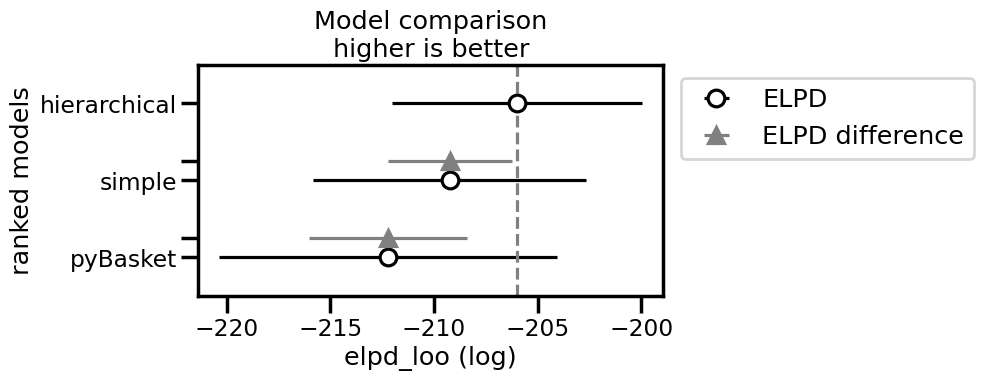

In [95]:
az.plot_compare(df_comp_loo);

# Save results

Save all the results to check in another notebook.

In [96]:
expr_df_filtered.shape, expr_df_selected.shape, len(class_labels), len(cluster_labels), patient_df.shape

((303, 19957), (303, 500), 303, 303, (303, 5))

In [97]:
drug_name, C

('Docetaxel', 5)

In [98]:
save_data = {
    'expr_df_filtered': expr_df_filtered,
    'expr_df_selected': expr_df_selected,
    'drug_response': drug_response,
    'class_labels': class_labels,
    'cluster_labels': cluster_labels,
    'patient_df': patient_df,
    'stacked_posterior': stacked_pyBasket,
    'trace': trace_pyBasket,
    'importance_df': importance_df
}
save_obj(save_data, os.path.join('results', 'patient_analysis_%s_cluster_%d.p' % (drug_name, C)))

2023-07-01 17:05:36.624 | INFO     | pyBasket.common:save_obj:64 - Saving <class 'dict'> to results/patient_analysis_Docetaxel_cluster_5.p


In [99]:
patient_df.to_csv(os.path.join('results', 'patient_analysis_%s_cluster_%d.csv' % (drug_name, C)))